In [1]:
!pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attempt

In [2]:
import tensorflow as tf
import numpy as np
import sys

print("--- Phiên bản thư viện ---")
print(f"Python version: {sys.version}")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU được TensorFlow nhận diện: {gpus}")
    try:
        details = tf.config.experimental.get_device_details(gpus[0])
        print(f"Chi tiết GPU: {details.get('device_name', 'Không có tên')}")
    except Exception as e:
        print(f"Không lấy được chi tiết GPU hoặc build info: {e}")
else:
    print("Không tìm thấy GPU.")
print("---------------------------")

2025-05-16 02:37:17.976746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747363038.190391      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747363038.255355      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


--- Phiên bản thư viện ---
Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
TensorFlow version: 2.18.0
NumPy version: 1.26.4
GPU được TensorFlow nhận diện: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Chi tiết GPU: Tesla T4
---------------------------


In [3]:
import os
import pandas as pd
import torch
import math
import pickle
from tqdm.notebook import tqdm
import math
import shutil
import gc

In [4]:
file_path = "/kaggle/input/text-and-label/data.csv"
print(f"Đang đọc dữ liệu từ: {file_path}")

try:
    df = pd.read_csv(file_path, usecols=['content', 'label'])
    print("Đã đọc xong dữ liệu.")
    print(f"Tổng số dòng: {len(df)}")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file tại đường dẫn {file_path}")
except Exception as e:
    print(f"Lỗi khi đọc file: {e}")

Đang đọc dữ liệu từ: /kaggle/input/text-and-label/data.csv
Đã đọc xong dữ liệu.
Tổng số dòng: 38854


In [5]:
print(f"Số lượng giá trị null trong content: {df['content'].isnull().sum()}")
print(f"Số lượng giá trị null trong label: {df['label'].isnull().sum()}")

df = df.dropna()
print(f"Số lượng dòng sau khi loại bỏ null: {len(df)}")

print(f"Phân phối nhãn:\n{df['label'].value_counts()}")

import re

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['content_processed'] = df['content'].apply(preprocess_text)

Số lượng giá trị null trong content: 24
Số lượng giá trị null trong label: 0
Số lượng dòng sau khi loại bỏ null: 38830
Phân phối nhãn:
label
POS    20078
NEG    11510
NEU     7242
Name: count, dtype: int64


In [6]:
X = df['content_processed'].values
y = df['label'].values

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

print("Bắt đầu cân bằng dữ liệu theo nhãn...")

min_samples_per_class = df['label'].value_counts().min()
print(f"Số lượng mẫu mục tiêu cho mỗi nhãn sau khi cân bằng: {min_samples_per_class}") # Sẽ là 7242

df_balanced_list = []
for label_value in df['label'].unique():
    df_label_subset = df[df['label'] == label_value]
    df_sampled_subset = df_label_subset.sample(n=min_samples_per_class, random_state=42, replace=False)
    df_balanced_list.append(df_sampled_subset)

df_balanced = pd.concat(df_balanced_list)

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nPhân phối nhãn sau khi cân bằng:")
print(df_balanced['label'].value_counts())
print(f"Tổng số mẫu sau khi cân bằng: {len(df_balanced)}")

X_balanced = df_balanced['content_processed'].values
y_balanced = df_balanced['label'].values


print("\nĐang chia tập dữ liệu đã cân bằng...")
X_temp, X_test, y_temp_str, y_test_str = train_test_split(
    X_balanced, 
    y_balanced, 
    test_size=0.1,
    stratify=y_balanced,
    random_state=42
)

val_size_from_temp = 0.1 / (1.0 - 0.1)

X_train, X_val, y_train_str, y_val_str = train_test_split(
    X_temp, 
    y_temp_str, 
    test_size=val_size_from_temp, 
    stratify=y_temp_str,
    random_state=42
)

print(f"\nSố lượng mẫu trong tập huấn luyện (X_train): {len(X_train)}")
print(f"Phân phối nhãn trong X_train:\n{pd.Series(y_train_str).value_counts().to_string()}")

print(f"\nSố lượng mẫu trong tập validation (X_val): {len(X_val)}")
print(f"Phân phối nhãn trong X_val:\n{pd.Series(y_val_str).value_counts().to_string()}")

print(f"\nSố lượng mẫu trong tập kiểm thử (X_test): {len(X_test)}")
print(f"Phân phối nhãn trong X_test:\n{pd.Series(y_test_str).value_counts().to_string()}")

print("\nChia tập dữ liệu (đã cân bằng) hoàn thành.")

Bắt đầu cân bằng dữ liệu theo nhãn...
Số lượng mẫu mục tiêu cho mỗi nhãn sau khi cân bằng: 7242

Phân phối nhãn sau khi cân bằng:
label
NEG    7242
POS    7242
NEU    7242
Name: count, dtype: int64
Tổng số mẫu sau khi cân bằng: 21726

Đang chia tập dữ liệu đã cân bằng...

Số lượng mẫu trong tập huấn luyện (X_train): 17380
Phân phối nhãn trong X_train:
NEU    5794
NEG    5793
POS    5793

Số lượng mẫu trong tập validation (X_val): 2173
Phân phối nhãn trong X_val:
NEG    725
POS    724
NEU    724

Số lượng mẫu trong tập kiểm thử (X_test): 2173
Phân phối nhãn trong X_test:
POS    725
NEU    724
NEG    724

Chia tập dữ liệu (đã cân bằng) hoàn thành.


In [8]:
from sklearn.preprocessing import LabelEncoder

print("Đang mã hóa nhãn...")
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_str)
y_val = label_encoder.transform(y_val_str)
y_test = label_encoder.transform(y_test_str)

# Chuyển thành kiểu float32 (hoặc int32)
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)

print(f"Mapping nhãn: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")
print("Mã hóa nhãn hoàn thành.")

Đang mã hóa nhãn...
Mapping nhãn: {'NEG': 0, 'NEU': 1, 'POS': 2}
Mã hóa nhãn hoàn thành.


In [9]:
from transformers import AutoTokenizer, TFAutoModel
print("Đang tải Tokenizer và PhoBERT encoder...")
phobert_model_name = "vinai/phobert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(phobert_model_name)
phobert_encoder = TFAutoModel.from_pretrained(phobert_model_name, from_pt=True)
print("Tokenizer và PhoBERT encoder đã tải xong.")

Đang tải Tokenizer và PhoBERT encoder...


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

I0000 00:00:1747363071.503996      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747363071.504760      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch mod

Tokenizer và PhoBERT encoder đã tải xong.


In [10]:
def get_phobert_embeddings_batch_optimized(
    texts, 
    phobert_model, 
    tokenizer, 
    max_length, 
    final_save_path, # Đường dẫn lưu file embedding cuối cùng của tập này
    batch_size=16,   # Nên bắt đầu với batch_size nhỏ
    temp_parent_dir="/kaggle/working/temp_embedding_batches", # Thư mục cha cho các batch tạm
    dtype_to_save=np.float16 # Lưu dưới dạng float16 để giảm dung lượng
):
    """
    Trích xuất PhoBERT embeddings, chuyển sang dtype_to_save, lưu từng batch ra file tạm,
    sau đó ghép lại, lưu kết quả cuối cùng vào final_save_path, rồi xóa file tạm.
    """
    num_samples = len(texts)
    if num_samples == 0:
        print(f"Không có mẫu nào trong {os.path.basename(final_save_path)}, bỏ qua.")
        return np.array([], dtype=dtype_to_save)
        
    embedding_dim = phobert_model.config.hidden_size

    # Tạo thư mục tạm cụ thể cho lần chạy này (ví dụ: /kaggle/working/temp_embedding_batches/temp_X_train_embed_batches)
    base_output_filename = os.path.basename(final_save_path)
    # Làm cho tên thư mục tạm an toàn hơn
    safe_temp_subdir_name = "".join(c if c.isalnum() else "_" for c in f"temp_{os.path.splitext(base_output_filename)[0]}_data")
    temp_batch_specific_dir = os.path.join(temp_parent_dir, safe_temp_subdir_name)

    if os.path.exists(temp_batch_specific_dir):
        print(f"Xóa thư mục tạm cũ: {temp_batch_specific_dir}")
        shutil.rmtree(temp_batch_specific_dir)
    os.makedirs(temp_batch_specific_dir, exist_ok=True)
    
    num_batches = math.ceil(num_samples / batch_size)
    print(f"Bắt đầu trích xuất embedding cho {num_samples} mẫu cho file '{base_output_filename}'.")
    print(f"Batch size: {batch_size}, Số batches: {num_batches}, Dtype lưu trữ: {dtype_to_save}.")
    print(f"Các batch tạm thời sẽ được lưu trong: {temp_batch_specific_dir}")

    physical_devices = tf.config.list_physical_devices('GPU')
    device_to_use = '/CPU:0' 

    if physical_devices:
        device_to_use = '/GPU:0' 
        print(f"Sử dụng GPU: {device_to_use} (Path vật lý: {physical_devices[0].name})")
    else:
        print("Sử dụng CPU.")

    batch_file_paths = []
    failed_batch_indices = []

    with tf.device(device_to_use):
        print(f"Đang thực thi trên thiết bị: {device_to_use}")
        for i in tqdm(range(num_batches), desc=f"Processing {base_output_filename}"):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
            
            current_batch_texts_slice = texts[start_idx:end_idx]
            if len(current_batch_texts_slice) == 0:
                continue

            # Khai báo trước để đảm bảo dọn dẹp trong finally
            batch_texts_list_for_tokenizer = None
            encoded_input = None
            input_ids_tensor = None
            attention_mask_tensor = None
            model_outputs = None
            batch_embeddings_tensor_from_model = None
            batch_embeddings_numpy_array_typed = None
            
            try:
                if not isinstance(current_batch_texts_slice, list):
                    batch_texts_list_for_tokenizer = current_batch_texts_slice.tolist()
                else:
                    batch_texts_list_for_tokenizer = current_batch_texts_slice

                encoded_input = tokenizer(
                    batch_texts_list_for_tokenizer,
                    padding='max_length',
                    truncation=True,
                    max_length=max_length,
                    return_tensors='tf'
                )
                
                input_ids_tensor = encoded_input['input_ids']
                attention_mask_tensor = encoded_input['attention_mask']

                model_outputs = phobert_model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor, training=False)
                batch_embeddings_tensor_from_model = model_outputs.last_hidden_state
                # Chuyển sang NumPy và dtype mong muốn (float16)
                batch_embeddings_numpy_array_typed = batch_embeddings_tensor_from_model.numpy().astype(dtype_to_save)
                
                batch_file_path = os.path.join(temp_batch_specific_dir, f"batch_{i:05d}.npy")
                np.save(batch_file_path, batch_embeddings_numpy_array_typed)
                batch_file_paths.append(batch_file_path)

            except Exception as e_batch:
                print(f"\n!!! LỖI ở batch {i} (chỉ số {start_idx}-{end_idx-1}) cho file {base_output_filename}: {type(e_batch).__name__} - {e_batch} !!!")
                print("Batch này sẽ BỊ BỎ QUA. Đang cố gắng dọn dẹp và tiếp tục...")
                failed_batch_indices.append(i)
            finally:
                del current_batch_texts_slice
                if batch_texts_list_for_tokenizer is not None: del batch_texts_list_for_tokenizer
                if encoded_input is not None: del encoded_input
                if input_ids_tensor is not None: del input_ids_tensor
                if attention_mask_tensor is not None: del attention_mask_tensor
                if model_outputs is not None: del model_outputs
                if batch_embeddings_tensor_from_model is not None: del batch_embeddings_tensor_from_model
                if batch_embeddings_numpy_array_typed is not None: del batch_embeddings_numpy_array_typed
                gc.collect()

    print(f"\nĐã xử lý xong các batches cho {base_output_filename}.")
    if failed_batch_indices:
        print(f"CẢNH BÁO: Các chỉ số batch bị lỗi (sẽ bị bỏ qua): {failed_batch_indices} cho {base_output_filename}.")
        print(f"Dữ liệu cho {base_output_filename} có thể bị thiếu {len(failed_batch_indices) * batch_size} mẫu (ước tính).")

    if not batch_file_paths:
        print(f"Không có batch nào được xử lý thành công cho {base_output_filename}.")
        if os.path.exists(temp_batch_specific_dir): shutil.rmtree(temp_batch_specific_dir)
        return np.array([], dtype=dtype_to_save)

    print(f"Bắt đầu ghép các file batch tạm cho {base_output_filename}...")
    all_loaded_batch_data = []
    for batch_file in tqdm(batch_file_paths, desc=f"Concatenating for {base_output_filename}"):
        try:
            loaded_single_batch = np.load(batch_file)
            all_loaded_batch_data.append(loaded_single_batch)
        except Exception as e_load:
            print(f"Lỗi khi load file batch {batch_file}: {e_load}. Bỏ qua file này.")
            continue
    
    if not all_loaded_batch_data:
        print(f"Không load được batch nào từ file tạm cho {base_output_filename}.")
        if os.path.exists(temp_batch_specific_dir): shutil.rmtree(temp_batch_specific_dir)
        return np.array([], dtype=dtype_to_save)

    final_embeddings_array = np.concatenate(all_loaded_batch_data, axis=0)
    del all_loaded_batch_data; gc.collect()
    
    print(f"Đã ghép xong. Shape cuối cùng cho {base_output_filename}: {final_embeddings_array.shape}")
    
    # Đảm bảo thư mục lưu cuối cùng tồn tại
    final_save_dir_for_file = os.path.dirname(final_save_path)
    if final_save_dir_for_file : os.makedirs(final_save_dir_for_file, exist_ok=True)
        
    np.save(final_save_path, final_embeddings_array)
    print(f"ĐÃ LƯU embedding cuối cùng (dtype: {final_embeddings_array.dtype}) vào: {final_save_path}")
    
    try:
        shutil.rmtree(temp_batch_specific_dir)
        print(f"Đã xóa thư mục tạm: {temp_batch_specific_dir}")
    except Exception as e_clean:
        print(f"Lỗi khi xóa thư mục tạm {temp_batch_specific_dir}: {e_clean}")
        
    return final_embeddings_array

In [11]:
MAX_LEN = 128
NUM_LABELS = len(label_encoder.classes_)

BATCH_SIZE_EMBEDDING = 16 
TARGET_DTYPE = np.float16

save_dir = '/kaggle/working/precomputed_data/' 
os.makedirs(save_dir, exist_ok=True) 

temp_dir_for_batches = "/kaggle/working/temp_embedding_batches"
os.makedirs(temp_dir_for_batches, exist_ok=True)


save_path_train = os.path.join(save_dir, 'X_train_embed.npy')
print(f"\nBắt đầu tiền xử lý embedding cho tập Train (sẽ lưu vào {save_path_train})...")
X_train_embed = get_phobert_embeddings_batch_optimized(
    X_train,
    phobert_encoder, 
    tokenizer, 
    MAX_LEN,
    final_save_path=save_path_train,
    batch_size=BATCH_SIZE_EMBEDDING,
    temp_parent_dir=temp_dir_for_batches,
    dtype_to_save=TARGET_DTYPE
)
if X_train_embed.size > 0:
    print(f"Shape của X_train_embed (dtype: {X_train_embed.dtype}): {X_train_embed.shape}")
else:
    print(f"LỖI: X_train_embed rỗng hoặc có vấn đề sau khi xử lý cho {save_path_train}.")


save_path_val = os.path.join(save_dir, 'X_val_embed.npy')
print(f"\nBắt đầu tiền xử lý embedding cho tập Validation (sẽ lưu vào {save_path_val})...")
X_val_embed = get_phobert_embeddings_batch_optimized(
    X_val, 
    phobert_encoder, 
    tokenizer, 
    MAX_LEN,
    final_save_path=save_path_val,
    batch_size=BATCH_SIZE_EMBEDDING,
    temp_parent_dir=temp_dir_for_batches,
    dtype_to_save=TARGET_DTYPE
)
if X_val_embed.size > 0:
    print(f"Shape của X_val_embed (dtype: {X_val_embed.dtype}): {X_val_embed.shape}")
else:
    print(f"LỖI: X_val_embed rỗng hoặc có vấn đề sau khi xử lý cho {save_path_val}.")


save_path_test = os.path.join(save_dir, 'X_test_embed.npy')
print(f"\nBắt đầu tiền xử lý embedding cho tập Test (sẽ lưu vào {save_path_test})...")
X_test_embed = get_phobert_embeddings_batch_optimized(
    X_test, 
    phobert_encoder, 
    tokenizer, 
    MAX_LEN,
    final_save_path=save_path_test,
    batch_size=BATCH_SIZE_EMBEDDING,
    temp_parent_dir=temp_dir_for_batches,
    dtype_to_save=TARGET_DTYPE
)
if X_test_embed.size > 0:
    print(f"Shape của X_test_embed (dtype: {X_test_embed.dtype}): {X_test_embed.shape}")
else:
    print(f"LỖI: X_test_embed rỗng hoặc có vấn đề sau khi xử lý cho {save_path_test}.")


print("\nĐang giải phóng phobert_encoder...")
if 'phobert_encoder' in globals():
    del phobert_encoder
    print("Đã xóa phobert_encoder.")
gc.collect()
print("Đã gọi gc.collect().")

print(f"\nKiểm tra lại: các file embedding đã được lưu trong '{save_dir}' bởi hàm trích xuất.")

print("\nĐang lưu label...")
if 'y_train' in globals() and isinstance(y_train, np.ndarray):
    np.save(os.path.join(save_dir, 'y_train.npy'), y_train)
if 'y_val' in globals() and isinstance(y_val, np.ndarray):
    np.save(os.path.join(save_dir, 'y_val.npy'), y_val)
if 'y_test' in globals() and isinstance(y_test, np.ndarray):
    np.save(os.path.join(save_dir, 'y_test.npy'), y_test)
print("=> Đã lưu label (nếu tồn tại và là numpy array).")

print("\nĐang lưu label encoder...")
if 'label_encoder' in globals():
    with open(os.path.join(save_dir, 'label_encoder.pkl'), 'wb') as f:
        pickle.dump(label_encoder, f)
    print("=> Đã lưu label encoder.")
else:
    print("Biến 'label_encoder' không tồn tại, không thể lưu.")

print(f"\n---> Đã lưu tất cả dữ liệu tiền xử lý (nếu có) vào thư mục: {save_dir} <---")

print("\nCác file đã lưu trong save_dir:")
if os.path.exists(save_dir):
    for item in os.listdir(save_dir):
        item_path = os.path.join(save_dir, item)
        if os.path.isfile(item_path):
            size_mb = os.path.getsize(item_path) / (1024 * 1024)
            print(f"- {item}: {size_mb:.2f} MB")
        elif os.path.isdir(item_path):
             print(f"- {item} (directory)")
else:
    print(f"Thư mục {save_dir} không tồn tại.")

print("\nCác file trong thư mục làm việc hiện tại của Kaggle (/kaggle/working/):")
!ls -lh /kaggle/working/


Bắt đầu tiền xử lý embedding cho tập Train (sẽ lưu vào /kaggle/working/precomputed_data/X_train_embed.npy)...
Bắt đầu trích xuất embedding cho 17380 mẫu cho file 'X_train_embed.npy'.
Batch size: 16, Số batches: 1087, Dtype lưu trữ: <class 'numpy.float16'>.
Các batch tạm thời sẽ được lưu trong: /kaggle/working/temp_embedding_batches/temp_X_train_embed_data
Sử dụng GPU: /GPU:0 (Path vật lý: /physical_device:GPU:0)
Đang thực thi trên thiết bị: /GPU:0


Processing X_train_embed.npy:   0%|          | 0/1087 [00:00<?, ?it/s]


Đã xử lý xong các batches cho X_train_embed.npy.
Bắt đầu ghép các file batch tạm cho X_train_embed.npy...


Concatenating for X_train_embed.npy:   0%|          | 0/1087 [00:00<?, ?it/s]

Đã ghép xong. Shape cuối cùng cho X_train_embed.npy: (17380, 128, 768)
ĐÃ LƯU embedding cuối cùng (dtype: float16) vào: /kaggle/working/precomputed_data/X_train_embed.npy
Đã xóa thư mục tạm: /kaggle/working/temp_embedding_batches/temp_X_train_embed_data
Shape của X_train_embed (dtype: float16): (17380, 128, 768)

Bắt đầu tiền xử lý embedding cho tập Validation (sẽ lưu vào /kaggle/working/precomputed_data/X_val_embed.npy)...
Bắt đầu trích xuất embedding cho 2173 mẫu cho file 'X_val_embed.npy'.
Batch size: 16, Số batches: 136, Dtype lưu trữ: <class 'numpy.float16'>.
Các batch tạm thời sẽ được lưu trong: /kaggle/working/temp_embedding_batches/temp_X_val_embed_data
Sử dụng GPU: /GPU:0 (Path vật lý: /physical_device:GPU:0)
Đang thực thi trên thiết bị: /GPU:0


Processing X_val_embed.npy:   0%|          | 0/136 [00:00<?, ?it/s]


Đã xử lý xong các batches cho X_val_embed.npy.
Bắt đầu ghép các file batch tạm cho X_val_embed.npy...


Concatenating for X_val_embed.npy:   0%|          | 0/136 [00:00<?, ?it/s]

Đã ghép xong. Shape cuối cùng cho X_val_embed.npy: (2173, 128, 768)
ĐÃ LƯU embedding cuối cùng (dtype: float16) vào: /kaggle/working/precomputed_data/X_val_embed.npy
Đã xóa thư mục tạm: /kaggle/working/temp_embedding_batches/temp_X_val_embed_data
Shape của X_val_embed (dtype: float16): (2173, 128, 768)

Bắt đầu tiền xử lý embedding cho tập Test (sẽ lưu vào /kaggle/working/precomputed_data/X_test_embed.npy)...
Bắt đầu trích xuất embedding cho 2173 mẫu cho file 'X_test_embed.npy'.
Batch size: 16, Số batches: 136, Dtype lưu trữ: <class 'numpy.float16'>.
Các batch tạm thời sẽ được lưu trong: /kaggle/working/temp_embedding_batches/temp_X_test_embed_data
Sử dụng GPU: /GPU:0 (Path vật lý: /physical_device:GPU:0)
Đang thực thi trên thiết bị: /GPU:0


Processing X_test_embed.npy:   0%|          | 0/136 [00:00<?, ?it/s]


Đã xử lý xong các batches cho X_test_embed.npy.
Bắt đầu ghép các file batch tạm cho X_test_embed.npy...


Concatenating for X_test_embed.npy:   0%|          | 0/136 [00:00<?, ?it/s]

Đã ghép xong. Shape cuối cùng cho X_test_embed.npy: (2173, 128, 768)
ĐÃ LƯU embedding cuối cùng (dtype: float16) vào: /kaggle/working/precomputed_data/X_test_embed.npy
Đã xóa thư mục tạm: /kaggle/working/temp_embedding_batches/temp_X_test_embed_data
Shape của X_test_embed (dtype: float16): (2173, 128, 768)

Đang giải phóng phobert_encoder...
Đã xóa phobert_encoder.
Đã gọi gc.collect().

Kiểm tra lại: các file embedding đã được lưu trong '/kaggle/working/precomputed_data/' bởi hàm trích xuất.

Đang lưu label...
=> Đã lưu label (nếu tồn tại và là numpy array).

Đang lưu label encoder...
=> Đã lưu label encoder.

---> Đã lưu tất cả dữ liệu tiền xử lý (nếu có) vào thư mục: /kaggle/working/precomputed_data/ <---

Các file đã lưu trong save_dir:
- y_val.npy: 0.01 MB
- y_train.npy: 0.07 MB
- label_encoder.pkl: 0.00 MB
- y_test.npy: 0.01 MB
- X_test_embed.npy: 407.44 MB
- X_train_embed.npy: 3258.75 MB
- X_val_embed.npy: 407.44 MB

Các file trong thư mục làm việc hiện tại của Kaggle (/kaggle/wo

In [12]:
from sklearn.preprocessing import LabelEncoder

load_dir = '/kaggle/working/precomputed_data/'
train_embed_path = os.path.join(load_dir, 'X_train_embed.npy')
val_embed_path = os.path.join(load_dir, 'X_val_embed.npy')
test_embed_path = os.path.join(load_dir, 'X_test_embed.npy')
y_train_path = os.path.join(load_dir, 'y_train.npy')
y_val_path = os.path.join(load_dir, 'y_val.npy')
y_test_path = os.path.join(load_dir, 'y_test.npy')
encoder_path = os.path.join(load_dir, 'label_encoder.pkl')

embeddings_loaded = False

if os.path.exists(train_embed_path):
    print(f"Tìm thấy dữ liệu tiền xử lý trong {load_dir}. Đang tải...")
    try:
        X_train_embed = np.load(train_embed_path)
        X_val_embed = np.load(val_embed_path)
        X_test_embed = np.load(test_embed_path)

        y_train = np.load(y_train_path)
        y_val = np.load(y_val_path)
        y_test = np.load(y_test_path)

        with open(encoder_path, 'rb') as f:
            label_encoder = pickle.load(f)

        print("\n---> Đã tải xong dữ liệu tiền xử lý! <---")
        print(f"Shape của X_train_embed: {X_train_embed.shape}")
        print(f"Dtype của X_train_embed: {X_train_embed.dtype}") 
        print(f"Mapping nhãn từ label_encoder đã tải: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

        embeddings_loaded = True

    except Exception as e:
        print(f"Lỗi khi tải dữ liệu: {e}")
        print("Sẽ cần chạy lại bước trích xuất embedding.")
        embeddings_loaded = False
else:
    print(f"Không tìm thấy dữ liệu tiền xử lý trong {load_dir}.")
    print("chạy cell trích xuất embedding trước nhé.")
    embeddings_loaded = False

Tìm thấy dữ liệu tiền xử lý trong /kaggle/working/precomputed_data/. Đang tải...

---> Đã tải xong dữ liệu tiền xử lý! <---
Shape của X_train_embed: (17380, 128, 768)
Dtype của X_train_embed: float16
Mapping nhãn từ label_encoder đã tải: {'NEG': 0, 'NEU': 1, 'POS': 2}


In [13]:
import tensorflow as tf 
from tensorflow.keras import layers, models
from tensorflow.keras import metrics as tf_metrics
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
import os
import datetime

def build_bilstm_attention(input_shape=(MAX_LEN, 768), num_labels=NUM_LABELS):
    embedding_input = layers.Input(shape=input_shape, name="embedding_input", dtype=tf.float32) 
    bilstm_layer = layers.Bidirectional(
        layers.LSTM(64, return_sequences=True, recurrent_dropout=1e-7) 
    )(embedding_input)
    try:
        attention_output = layers.Attention(use_scale=True)([bilstm_layer, bilstm_layer])
    except TypeError: 
        print("Cảnh báo: layers.Attention không hỗ trợ 'use_scale=True'. Sử dụng không có scale.")
        attention_output = layers.Attention()([bilstm_layer, bilstm_layer])
    pooled_output = layers.GlobalMaxPooling1D()(attention_output)
    x = layers.Dense(64, activation='relu')(pooled_output)
    x = layers.Dropout(0.5)(x) 
    output_layer = layers.Dense(num_labels, activation='softmax', name='sentiment_output')(x)

    model = models.Model(inputs=embedding_input, outputs=output_layer)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) 
    loss = 'sparse_categorical_crossentropy'
    metrics_list = ['accuracy'] 
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics_list)
    print("--- Model BiLSTM-Attention đã được build và compile (Metrics: CHỈ CÓ 'accuracy') ---")
    return model

In [14]:
model_input_shape = (X_train_embed.shape[1], X_train_embed.shape[2]) 
if 'label_encoder' in globals() and label_encoder is not None:
    NUM_LABELS = len(label_encoder.classes_)
else:
    print("LỖI: label_encoder chưa được load, không thể xác định NUM_LABELS chính xác.")
    NUM_LABELS = 3

model = build_bilstm_attention(input_shape=model_input_shape, num_labels=NUM_LABELS)
model.summary()

--- Model BiLSTM-Attention đã được build và compile (Metrics: CHỈ CÓ 'accuracy') ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ embedding_input           │ (None, 128, 768)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 128, 128)       │        426,496 │ embedding_input[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 128, 128)       │              1 │ bidirectional[0][0],   │
│                           │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 128)            │              0 │ attention[0][0]        │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          8,256 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentiment_output (Dense)  │ (None, 3)              │            195 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 434,948 (1.66 MB)

 Trainable params: 434,948 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
print("--- Chuẩn bị tf.data.Dataset ---")
train_dataset_embed = tf.data.Dataset.from_tensor_slices((X_train_embed, y_train))
# Sử dụng len(X_train_embed) cho buffer_size là tối ưu nhất cho việc xáo trộn
train_dataset_embed = train_dataset_embed.shuffle(buffer_size=len(X_train_embed), reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset_embed = tf.data.Dataset.from_tensor_slices((X_val_embed, y_val))
val_dataset_embed = val_dataset_embed.batch(32).prefetch(tf.data.AUTOTUNE)
print("Đã tạo xong Dataset cho train và validation.")

# 2. Định nghĩa Callbacks
print("\n--- Định nghĩa Callbacks ---")

# EarlyStopping: Dừng sớm nếu không có cải thiện
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=7, # Cho phép chờ 7 epochs không cải thiện trước khi dừng
    restore_best_weights=True, # Khôi phục trọng số tốt nhất khi dừng
    verbose=1 # In thông báo khi dừng
)
print("Đã định nghĩa EarlyStopping.")

# ReduceLROnPlateau: Giảm learning rate khi việc học chậm lại
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, # Giảm LR còn 20% giá trị hiện tại
    patience=3, # Giảm LR nếu val_loss không cải thiện sau 3 epochs
    min_lr=1e-7,  # Learning rate không giảm xuống dưới mức này
    verbose=1 # In thông báo khi giảm LR
)
print("Đã định nghĩa ReduceLROnPlateau.")

# ModelCheckpoint: Lưu lại model tốt nhất trong quá trình huấn luyện
checkpoint_dir = "/kaggle/working/model_checkpoints/" # Thư mục lưu checkpoints trên Kaggle
os.makedirs(checkpoint_dir, exist_ok=True) # Tạo thư mục nếu chưa có
# Tên file checkpoint với thông tin epoch và val_loss
checkpoint_filepath = os.path.join(checkpoint_dir, "model_epoch-{epoch:02d}_valloss-{val_loss:.4f}.keras")

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,        # Chỉ lưu model tốt nhất (dựa trên val_loss)
    save_weights_only=False,    # Lưu toàn bộ model (kiến trúc + trọng số + optimizer state)
    mode='min',                 # 'min' vì ta theo dõi 'val_loss' (càng nhỏ càng tốt)
    verbose=1 # In thông báo khi lưu checkpoint
)
print(f"Đã định nghĩa ModelCheckpoint. Model tốt nhất sẽ được lưu vào: {checkpoint_dir}")

# TensorBoard: Theo dõi quá trình huấn luyện bằng giao diện web
# Tạo thư mục logs riêng cho mỗi lần chạy dựa trên timestamp
log_dir_tensorboard = os.path.join("/kaggle/working/logs/fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir_tensorboard, exist_ok=True)

tensorboard_callback = TensorBoard(
    log_dir=log_dir_tensorboard,
    histogram_freq=1,       # Ghi histogram của weights mỗi epoch (có thể tắt = 0 nếu muốn nhẹ hơn)
    write_graph=True,       # Ghi đồ thị model
    write_images=False,     # Không ghi ảnh (thường không cần thiết)
    update_freq='epoch',    # Cập nhật log mỗi epoch
    profile_batch=0         # Tắt profiling để tránh overhead/lỗi
)
print(f"Đã định nghĩa TensorBoard. Logs sẽ được lưu vào: {log_dir_tensorboard}")

# Tập hợp tất cả callbacks lại
all_callbacks = [
    early_stopping, 
    reduce_lr, 
    model_checkpoint, 
    tensorboard_callback
]
print("Đã tổng hợp danh sách callbacks.")

# 3. Huấn luyện Model
print("\n--- Bắt đầu huấn luyện model với các callbacks đã chuẩn bị ---")
# Giả sử 'model' là biến chứa model đã được compile của m
# Ví dụ: model = build_bilstm_attention() (đã chạy ở cell trước)

history = model.fit(
    train_dataset_embed,
    validation_data=val_dataset_embed,
    epochs=30, # SỬA LỖI TYPO: epochs=30 (không phải epochs330)
    callbacks=all_callbacks,
    verbose=1 # In log chi tiết cho mỗi epoch
)

print("\n--- Hoàn thành huấn luyện model ---")

--- Chuẩn bị tf.data.Dataset ---
Đã tạo xong Dataset cho train và validation.

--- Định nghĩa Callbacks ---
Đã định nghĩa EarlyStopping.
Đã định nghĩa ReduceLROnPlateau.
Đã định nghĩa ModelCheckpoint. Model tốt nhất sẽ được lưu vào: /kaggle/working/model_checkpoints/
Đã định nghĩa TensorBoard. Logs sẽ được lưu vào: /kaggle/working/logs/fit/20250516-025111
Đã tổng hợp danh sách callbacks.

--- Bắt đầu huấn luyện model với các callbacks đã chuẩn bị ---
Epoch 1/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.5287 - loss: 0.9278
Epoch 1: val_loss improved from inf to 0.70123, saving model to /kaggle/working/model_checkpoints/model_epoch-01_valloss-0.7012.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 263s 459ms/step - accuracy: 0.5289 - loss: 0.9277 - val_accuracy: 0.6820 - val_loss: 0.7012 - learning_rate: 1.0000e-04
Epoch 2/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.6897 - loss: 0.6939
Epoch 2: val_loss improved from 0.70123 to 0.65278, saving model to /kaggle/working/mo

In [16]:
print("\n--- Đánh giá model trên tập test ---")
loss, acc = model.evaluate(X_test_embed, y_test)
print(f"Model Test Loss: {loss:.4f}")
print(f"Model Test Accuracy: {acc:.4f}")


--- Đánh giá model trên tập test ---
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.7458 - loss: 0.5842
Model Test Loss: 0.6037
Model Test Accuracy: 0.7308


68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.7458 - loss: 0.5842
Test accuracy: 0.7308


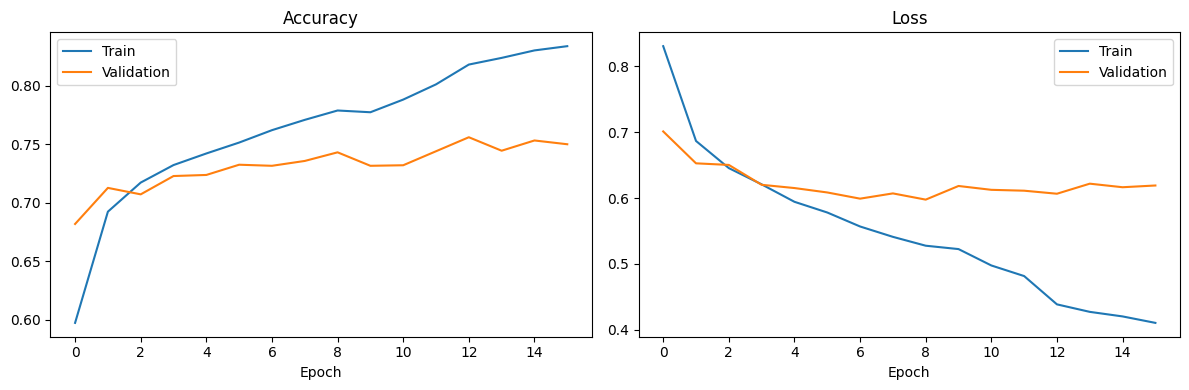

In [17]:
loss, accuracy = model.evaluate(X_test_embed, y_test)
print(f'Test accuracy: {accuracy:.4f}')

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
import os
import pickle
import numpy as np
import tensorflow as tf

if 'model' not in globals() and 'new_model' in globals():
    model_to_save = new_model
    print("Sử dụng biến 'new_model' để lưu.")
elif 'model' in globals():
    model_to_save = model
    print("Sử dụng biến 'model' để lưu.")
else:
    print("LỖI: Không tìm thấy biến model ('model' hoặc 'new_model') để lưu!")
    model_to_save = None 

if 'history' not in globals() and 'history_new' in globals():
    training_history = history_new
    print("Sử dụng biến 'history_new' cho lịch sử huấn luyện.")
elif 'history' in globals():
    training_history = history
    print("Sử dụng biến 'history' cho lịch sử huấn luyện.")
else:
    print("CẢNH BÁO: Không tìm thấy biến lịch sử huấn luyện ('history' hoặc 'history_new'). Một số thông số kết quả sẽ bị thiếu.")
    training_history = None


best_model_filename = 'sentiment_analyzer_best_model.keras'
best_model_save_path = os.path.join('/kaggle/working/', best_model_filename) 

if model_to_save is not None:
    model_to_save.save(best_model_save_path)
    print(f"\nĐã lưu model (với trọng số tốt nhất từ EarlyStopping) vào: {best_model_save_path}")
else:
    print("\nKhông có model để lưu.")

model_info_filename = 'sentiment_analyzer_model_info.pkl'
model_info_save_path = os.path.join('/kaggle/working/', model_info_filename)

best_epoch_num = None
final_val_loss = None
final_val_accuracy = None

if training_history is not None and model_to_save is not None:
    try:
        best_epoch_idx = np.argmin(training_history.history['val_loss'])
        best_epoch_num = best_epoch_idx + 1 # Epochs là 1-indexed
        final_val_loss = training_history.history['val_loss'][best_epoch_idx]
        final_val_accuracy = training_history.history['val_accuracy'][best_epoch_idx]
        print(f"Thông tin từ epoch tốt nhất (epoch {best_epoch_num}):")
        print(f"  - Val Loss: {final_val_loss:.4f}")
        print(f"  - Val Accuracy: {final_val_accuracy:.4f}")
    except KeyError as e:
        print(f"Lỗi khi truy cập history: {e}. 'val_loss' hoặc 'val_accuracy' có thể không có trong history.metrics.")
    except Exception as e:
        print(f"Lỗi không xác định khi xử lý history: {e}")


lstm_units = 64
dense_units = 64
recurrent_dropout_rate = 1e-7
dropout_rate = 0.5
learning_rate_initial = 1e-4

model_info = {
    'saved_model_filename': best_model_filename if model_to_save is not None else None,
    'max_len_sequence': MAX_LEN, 
    'num_labels': NUM_LABELS,
    'label_encoder_classes': list(label_encoder.classes_) if hasattr(label_encoder, 'classes_') else None,
    'architecture_details': {
        'lstm_units': lstm_units,
        'dense_units': dense_units,
        'recurrent_dropout': recurrent_dropout_rate,
        'dropout_after_dense': dropout_rate,
        'initial_learning_rate': learning_rate_initial,
        'loss_function': 'sparse_categorical_crossentropy',
        'optimizer': 'Adam'
    },
    # Kết quả huấn luyện tốt nhất (nếu history có)
    'best_training_results': {
        'best_epoch_number': best_epoch_num,
        'validation_loss': final_val_loss,
        'validation_accuracy': final_val_accuracy,
        'training_loss_at_best_val_epoch': training_history.history['loss'][best_epoch_idx] if training_history and best_epoch_idx < len(training_history.history['loss']) else None,
        'training_accuracy_at_best_val_epoch': training_history.history['accuracy'][best_epoch_idx] if training_history and best_epoch_idx < len(training_history.history['accuracy']) else None,
    } if training_history and best_epoch_num is not None else "Không có thông tin history chi tiết.",
    'notes': "Model BiLSTM with Attention for sentiment analysis. Trained on precomputed PhoBERT embeddings.",
    'save_timestamp': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

label_encoder_filename = 'sentiment_analyzer_label_encoder.pkl'
label_encoder_save_path = os.path.join('/kaggle/working/', label_encoder_filename)
if hasattr(label_encoder, 'classes_'):
    try:
        with open(label_encoder_save_path, 'wb') as f:
            pickle.dump(label_encoder, f)
        print(f"Đã lưu label_encoder vào: {label_encoder_save_path}")
        model_info['label_encoder_filename'] = label_encoder_filename # Thêm tên file vào model_info
    except Exception as e:
        print(f"Lỗi khi lưu label_encoder: {e}")
        model_info['label_encoder_filename'] = None
else:
    print("Không thể lưu label_encoder vì 'label_encoder' không hợp lệ hoặc chưa được fit.")
    model_info['label_encoder_filename'] = None


try:
    with open(model_info_save_path, 'wb') as f: 
        pickle.dump(model_info, f)
    print(f"Đã lưu các thông số model (model_info) vào: {model_info_save_path}")
except Exception as e:
    print(f"Lỗi khi lưu model_info: {e}")

print("\nHoàn thành quá trình lưu model và thông tin!")
print(f"File model: {best_model_save_path}")
print(f"File thông tin: {model_info_save_path}")
if model_info.get('label_encoder_filename'):
    print(f"File label encoder: {os.path.join('/kaggle/working/', model_info['label_encoder_filename'])}")

Sử dụng biến 'model' để lưu.
Sử dụng biến 'history' cho lịch sử huấn luyện.

Đã lưu model (với trọng số tốt nhất từ EarlyStopping) vào: /kaggle/working/sentiment_analyzer_best_model.keras
Thông tin từ epoch tốt nhất (epoch 9):
  - Val Loss: 0.5976
  - Val Accuracy: 0.7432
Đã lưu label_encoder vào: /kaggle/working/sentiment_analyzer_label_encoder.pkl
Đã lưu các thông số model (model_info) vào: /kaggle/working/sentiment_analyzer_model_info.pkl

Hoàn thành quá trình lưu model và thông tin!
File model: /kaggle/working/sentiment_analyzer_best_model.keras
File thông tin: /kaggle/working/sentiment_analyzer_model_info.pkl
File label encoder: /kaggle/working/sentiment_analyzer_label_encoder.pkl


In [19]:
import tensorflow as tf # Thêm import tensorflow
from tensorflow import keras # keras đã được import
import pickle
import numpy as np
from transformers import AutoTokenizer, TFAutoModel # Thêm TFAutoModel
import os # Thêm os để join path
import re # Thêm re

# --- 1. Load Model và Thông tin đã lưu ---
print("--- Đang tải model và thông tin cần thiết ---")

# Đường dẫn tới các file đã lưu (giả sử m đang ở thư mục chứa /kaggle/working/)
working_dir = '/kaggle/working/' # Hoặc đường dẫn tuyệt đối nếu cần
model_path = os.path.join(working_dir, 'sentiment_analyzer_best_model.keras')
model_info_path = os.path.join(working_dir, 'sentiment_analyzer_model_info.pkl')
# Tên file label_encoder sẽ lấy từ model_info

# Load model Keras đã huấn luyện
if os.path.exists(model_path):
    loaded_model = keras.models.load_model(model_path)
    print(f"Đã load model từ: {model_path}")
else:
    print(f"LỖI: Không tìm thấy model tại {model_path}")
    loaded_model = None # Hoặc exit

# Load model_info
if os.path.exists(model_info_path):
    with open(model_info_path, 'rb') as f:
        model_info = pickle.load(f)
    print(f"Đã load model_info từ: {model_info_path}")
    
    # Lấy MAX_LEN (sửa key cho đúng với lúc lưu)
    MAX_LEN = model_info.get('max_len_sequence') 
    if MAX_LEN is None:
        print("LỖI: Không tìm thấy 'max_len_sequence' trong model_info. Đặt tạm là 128.")
        MAX_LEN = 128
    else:
        print(f"MAX_LEN được load từ model_info: {MAX_LEN}")

    # Load label_encoder từ file riêng (tên file được lưu trong model_info)
    label_encoder_filename = model_info.get('label_encoder_filename')
    if label_encoder_filename:
        label_encoder_path = os.path.join(working_dir, label_encoder_filename)
        if os.path.exists(label_encoder_path):
            with open(label_encoder_path, 'rb') as f:
                label_encoder = pickle.load(f)
            print(f"Đã load label_encoder từ: {label_encoder_path}")
            print(f"Các lớp của label_encoder: {list(label_encoder.classes_)}")
        else:
            print(f"LỖI: Không tìm thấy file label_encoder tại {label_encoder_path}")
            label_encoder = None # Hoặc exit
    else:
        print("LỖI: Không có thông tin 'label_encoder_filename' trong model_info.")
        label_encoder = None # Hoặc exit
else:
    print(f"LỖI: Không tìm thấy model_info tại {model_info_path}")
    # Gán giá trị mặc định hoặc xử lý lỗi nếu không có model_info
    MAX_LEN = 128 
    label_encoder = None # Hoặc exit


# Load Tokenizer của PhoBERT
phobert_tokenizer_name = "vinai/phobert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(phobert_tokenizer_name)
print(f"Đã load Tokenizer: {phobert_tokenizer_name}")

# Load PhoBERT encoder model (cần thiết để tạo embedding từ text)
# Đây là model gốc của PhoBERT, không phải model đã fine-tune của m
print("Đang tải PhoBERT encoder model (dùng để trích xuất embedding)...")
try:
    phobert_encoder = TFAutoModel.from_pretrained(phobert_tokenizer_name, from_pt=True)
    print("Đã tải xong PhoBERT encoder model.")
except Exception as e:
    print(f"Lỗi khi tải PhoBERT encoder model: {e}")
    phobert_encoder = None # Hoặc exit


def preprocess_text_for_prediction(text):
    text = str(text).lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def predict_sentiment(text_input, keras_model, phobert_model_encoder, phobert_tokenizer, max_seq_len, lbl_encoder):
    if not all([keras_model, phobert_model_encoder, phobert_tokenizer, lbl_encoder]):
        print("Lỗi: Thiếu một trong các thành phần model hoặc tokenizer hoặc label encoder.")
        return None

    processed_text = preprocess_text_for_prediction(text_input)
    encoded_inputs = phobert_tokenizer(
        [processed_text],
        padding='max_length',
        truncation=True,
        max_length=max_seq_len,
        return_tensors='tf'
    )
    
    input_ids = encoded_inputs['input_ids']
    attention_mask = encoded_inputs['attention_mask']

    # c. Lấy embedding từ PhoBERT encoder
    # Đảm bảo chạy trên đúng device nếu có GPU
    physical_devices = tf.config.list_physical_devices('GPU')
    device_to_use = '/GPU:0' if physical_devices else '/CPU:0'
    
    with tf.device(device_to_use):
        phobert_outputs = phobert_model_encoder(input_ids=input_ids, attention_mask=attention_mask, training=False)
    
    # Lấy last_hidden_state làm embedding đầu vào cho model của m
    # Shape của nó sẽ là (1, max_seq_len, embedding_dim=768)
    input_embeddings_for_model = phobert_outputs.last_hidden_state 
    # Không cần .numpy() ở đây nếu model Keras của m nhận TF tensor làm input (thường là vậy)

    # d. Đưa embedding vào model đã huấn luyện của m để dự đoán
    prediction_probabilities = keras_model.predict(input_embeddings_for_model)

    # e. Lấy kết quả
    predicted_class_index = np.argmax(prediction_probabilities, axis=1)[0]
    predicted_label_text = lbl_encoder.inverse_transform([predicted_class_index])[0]
    confidence_score = float(prediction_probabilities[0][predicted_class_index])

    return {
        'text_input': text_input,
        'processed_text': processed_text,
        'label': predicted_label_text,
        'confidence': confidence_score,
        'prediction_vector': prediction_probabilities[0].tolist()
    }

# --- 3. Test với các câu ví dụ ---
if loaded_model and phobert_encoder and tokenizer and label_encoder and MAX_LEN:
    print("\n--- Bắt đầu dự đoán cho các câu test ---")
    test_texts = [
        "Sản phẩm này thực sự tuyệt vời, tôi rất hài lòng với chất lượng",
        "Dịch vụ khách hàng quá tệ, tôi sẽ không bao giờ quay lại nữa",
        "Món ăn bình thường, không có gì đặc biệt",
        "Quá thất vọng, không như quảng cáo",
        "Rất đáng tiền, sẽ mua lại ủng hộ shop!"
    ]

    for text_example in test_texts:
        result = predict_sentiment(
            text_example, 
            loaded_model, 
            phobert_encoder, 
            tokenizer, 
            MAX_LEN, 
            label_encoder
        )
        if result:
            print(f"\nVăn bản: {result['text_input']}")
            # print(f"Processed: {result['processed_text']}")
            print(f"  Nhãn dự đoán: {result['label']}")
            print(f"  Độ tin cậy: {result['confidence']:.2%}")
            # print(f"  Vector dự đoán: {result['prediction_vector']}")
            print("---")
else:
    print("\nKhông thể chạy dự đoán do thiếu model hoặc các thông tin cần thiết đã load bị lỗi.")



--- Đang tải model và thông tin cần thiết ---
Đã load model từ: /kaggle/working/sentiment_analyzer_best_model.keras
Đã load model_info từ: /kaggle/working/sentiment_analyzer_model_info.pkl
MAX_LEN được load từ model_info: 128
Đã load label_encoder từ: /kaggle/working/sentiment_analyzer_label_encoder.pkl
Các lớp của label_encoder: ['NEG', 'NEU', 'POS']
Đã load Tokenizer: vinai/phobert-base-v2
Đang tải PhoBERT encoder model (dùng để trích xuất embedding)...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Đã tải xong PhoBERT encoder model.

--- Bắt đầu dự đoán cho các câu test ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step

Văn bản: Sản phẩm này thực sự tuyệt vời, tôi rất hài lòng với chất lượng
  Nhãn dự đoán: POS
  Độ tin cậy: 91.91%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step

Văn bản: Dịch vụ khách hàng quá tệ, tôi sẽ không bao giờ quay lại nữa
  Nhãn dự đoán: NEG
  Độ tin cậy: 95.77%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

Văn bản: Món ăn bình thường, không có gì đặc biệt
  Nhãn dự đoán: NEU
  Độ tin cậy: 94.04%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step

Văn bản: Quá thất vọng, không như quảng cáo
  Nhãn dự đoán: NEG
  Độ tin cậy: 98.47%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step

Văn bản: Rất đáng tiền, sẽ mua lại ủng hộ shop!
  Nhãn dự đoán: POS
  Độ tin cậy: 96.68%
---


In [20]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np # Cần cho np.argmax trong predict_sentiment
import tensorflow as tf # Cần cho tf.device và tf.config trong predict_sentiment
from transformers import AutoTokenizer, TFAutoModel # Cần cho predict_sentiment
import pickle # Cần để load label_encoder nếu chưa
import os # Cần cho os.path.join
import re # Cần cho preprocess_text

def preprocess_text_for_prediction(text):
    text = str(text).lower()
    text = re.sub(r'<[^>]+>', '', text) 
    text = re.sub(r'http\S+', '', text) 
    text = re.sub(r'\s+', ' ', text)    
    return text.strip()

def predict_sentiment(text_input, keras_model, phobert_model_encoder, phobert_tokenizer, max_seq_len, lbl_encoder):
    if not all([keras_model, phobert_model_encoder, phobert_tokenizer, lbl_encoder]):
        print("Lỗi trong predict_sentiment: Thiếu một trong các thành phần model, tokenizer, hoặc label encoder.")
        return None
    if max_seq_len is None:
        print("Lỗi trong predict_sentiment: max_seq_len is None.")
        return None


    processed_text = preprocess_text_for_prediction(text_input)
    encoded_inputs = phobert_tokenizer(
        [processed_text],      
        padding='max_length',
        truncation=True,
        max_length=max_seq_len,
        return_tensors='tf'    
    )
    input_ids = encoded_inputs['input_ids']
    attention_mask = encoded_inputs['attention_mask']

    physical_devices = tf.config.list_physical_devices('GPU')
    device_to_use = '/GPU:0' if physical_devices else '/CPU:0'
    
    with tf.device(device_to_use):
        phobert_outputs = phobert_model_encoder(input_ids=input_ids, attention_mask=attention_mask, training=False)
    
    input_embeddings_for_model = phobert_outputs.last_hidden_state

    prediction_probabilities = keras_model.predict(input_embeddings_for_model, verbose=0) # Thêm verbose=0 để đỡ log

    predicted_class_index = np.argmax(prediction_probabilities, axis=1)[0]
    predicted_label_text = lbl_encoder.inverse_transform([predicted_class_index])[0]
    confidence_score = float(prediction_probabilities[0][predicted_class_index])

    return {
        'text_input': text_input,
        'processed_text': processed_text,
        'label': predicted_label_text,
        'confidence': confidence_score,
        'prediction_vector': prediction_probabilities[0].tolist()
    }

text_input_ui = widgets.Textarea( # Đổi tên biến để tránh trùng với text_input trong hàm on_button_clicked
    value='Sản phẩm này dùng cũng ổn, không quá tệ.', # Giá trị mặc định để test
    placeholder='Nhập văn bản cần phân tích...',
    description='Văn bản:',
    disabled=False,
    layout={'width': '95%', 'height': '100px'} # Điều chỉnh width một chút
)

analyze_button_ui = widgets.Button(description="Phân tích thái độ", button_style='success', icon='search') # Thêm icon
output_ui = widgets.Output() # Đổi tên biến

# Hàm xử lý khi nhấn nút
def on_analyze_button_clicked(b): # Đổi tên hàm cho rõ hơn
    with output_ui: # Dùng output_ui
        clear_output(wait=True)  # Xoá output cũ, wait=True để mượt hơn
        
        input_text_from_widget = text_input_ui.value.strip() # Dùng text_input_ui và strip()
        
        if not input_text_from_widget:
            print("Vui lòng nhập văn bản!")
            return

        # --- KIỂM TRA XEM CÁC BIẾN GLOBAL CẦN THIẾT ĐÃ CÓ CHƯA ---
        required_globals = ['loaded_model', 'phobert_encoder', 'tokenizer', 'MAX_LEN', 'label_encoder']
        missing_globals = [var_name for var_name in required_globals if var_name not in globals() or globals()[var_name] is None]
        
        if missing_globals:
            print(f"LỖI: Thiếu các biến global cần thiết để dự đoán: {', '.join(missing_globals)}")
            print("Vui lòng chạy lại các cell load model và thông tin ở trên trước.")
            return
        # --- HẾT KIỂM TRA ---

        print(f"Đang phân tích: \"{input_text_from_widget[:100]}{'...' if len(input_text_from_widget) > 100 else ''}\"")
        
        # Gọi hàm predict_sentiment với đầy đủ các tham số cần thiết
        result = predict_sentiment(
            input_text_from_widget,
            loaded_model,       # Model Keras đã huấn luyện
            phobert_encoder,    # Model PhoBERT gốc để lấy embedding
            tokenizer,          # Tokenizer của PhoBERT
            MAX_LEN,            # Max sequence length
            label_encoder       # LabelEncoder đã fit
        )
        
        if result:
            print(f"\nNhãn dự đoán: {result['label']}")
            print(f"Độ tin cậy: {result['confidence']:.2%}")

            # Vẽ biểu đồ
            labels_plot = label_encoder.classes_ # Lấy các lớp từ label_encoder
            prediction_vector_plot = result['prediction_vector']
            
            plt.figure(figsize=(8, 5)) # Tăng chiều cao một chút cho dễ nhìn
            bars = plt.bar(labels_plot, prediction_vector_plot, color=['#FF9999','#ADD8E6','#90EE90']) # Màu cho NEG, NEU, POS
            
            # Thêm giá trị trên mỗi cột
            for bar in bars:
                yval = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2%}', ha='center', va='bottom')

            plt.title('Biểu đồ xác suất dự đoán cho từng nhãn', fontsize=14)
            plt.xlabel('Nhãn cảm xúc', fontsize=12)
            plt.ylabel('Xác suất', fontsize=12)
            plt.ylim(0, 1.05) # Tăng giới hạn y một chút để text trên cột không bị cắt
            plt.xticks(rotation=0, ha='center', fontsize=10) # Để ngang cho dễ đọc nếu ít nhãn
            plt.yticks(fontsize=10)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout() # Tự động điều chỉnh layout cho đẹp
            plt.show()
        else:
            print("Không thể lấy được kết quả dự đoán. Vui lòng kiểm tra lại.")

# Gắn sự kiện
analyze_button_ui.on_click(on_analyze_button_clicked) # Dùng tên hàm đã đổi

# Hiển thị UI
print("--- Giao diện Phân tích Cảm xúc Văn bản ---")
display(widgets.VBox([text_input_ui, analyze_button_ui, output_ui])) # Bọc trong VBox cho đẹp hơn



--- Giao diện Phân tích Cảm xúc Văn bản ---


Tiêu cực:
Chán thật sự, làm gì cũng thấy sai sai, không đâu vào đâu cả. 😩
Bực mình ghê, sao lúc nào t cũng gặp phải mấy chuyện xui xẻo này vậy? 😠
Mệt mỏi rã rời, t chỉ muốn nằm bẹp dí một chỗ, không muốn làm gì hết. 😵
Thất vọng tràn trề, t đã cố gắng nhiều mà kết quả chẳng ra sao. 😞
Sao t thấy mọi thứ vô nghĩa quá vậy nè... 😔


Tích cực:

Yeahh! Cuối cùng cũng làm xong rồi, mừng rớt nước mắt luôn! 🎉🥳
Hôm nay t thấy vui vẻ, yêu đời lạ thường, chắc do trời đẹp á! 😄☀️
Tin tốt đâyyy! Mọi chuyện đang tiến triển thuận lợi lắm m ơi. ✨👍
Tuyệt vời! T biết mình có thể làm được mà, cảm giác tự tin ghê. 😎💪
Có m ở đây tâm sự là t thấy nhẹ nhõm hẳn, cảm ơn m nhiều nha! 😊💖


Trung tính:

Thông báo cho biết cuộc họp sẽ diễn ra vào ngày mai. 📄
T cần thêm thông tin để đưa ra quyết định cuối cùng. 🤔
Thời tiết hôm nay khá ổn định, không mưa không nắng gắt. ☁️
Báo cáo này trình bày các số liệu thống kê của quý trước. 📊
Quá trình xử lý dữ liệu đang được tiến hành theo kế hoạch. 💻
